In [851]:
import cv2
import numpy as np
import scipy as sci
from scipy.ndimage import gaussian_filter
from scipy import misc
from matplotlib import pyplot as plt
from scipy.stats import norm
from PIL import Image as pil_image

In [852]:
def img_show(img):
    return pil_image.fromarray(img.astype(np.uint8))

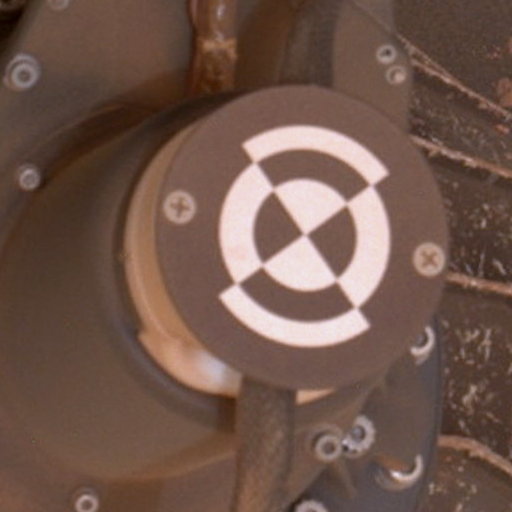

In [853]:
image = pil_image.open('marker_cut_rgb_512.png')
np_img = np.array(image)
image

In [854]:
class Convolution():
    def __create_padding(img, kernel):
        (iW, iH) = img.shape[:2]
        (kW, kH) = kernel.shape
        paddings = (
            (((iH + kH*2) // kH * kH) - iH) // 2, 
            (((iW + kW*2) // kW * kW) - iH) // 2,
        )
        return np.pad(img, (paddings, paddings, (0, 0)), 'constant', constant_values=0)
         
    def __convolve(img, kernel):
        (iH, iW, chans) = img.shape
        (kH, kW) = kernel.shape
        
        img_with_padding = Convolution.__create_padding(img, kernel)
        augmented_kernel = np.repeat(kernel[:, :, np.newaxis], 3, axis=2)
        
        result = np.zeros(img.shape)
        
        for x in range(iW):
            for y in range(iH):
                roi = img_with_padding[x:x + kW, y:y + kH]
                k = np.multiply(augmented_kernel, roi)
                result[x, y] = k.sum(axis=(0, 1))
                
        return result
    
    @staticmethod
    def run(img, kernel):
        return Convolution.__convolve(img, kernel)

In [855]:
class GaussianBlur():
    def __makeGaussian(size, sigma):
        x = np.arange(size)
        y = x[:,np.newaxis]
        x0 = y0 = size // 2
        result = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
        return result / result.sum()
    
    @staticmethod
    def run(img, shape):
        kernel = GaussianBlur.__makeGaussian(min(shape), 1)
        return Convolution.run(img, kernel)

In [856]:
class SobelFilter():
    def __round_theta(theta):
        for (x, y), value in np.ndenumerate(theta):
            value = np.degrees(value)
            if value < 22.5 or value > 157.5:
                theta[x, y] = 0.
            elif value < 67.5 or value > 22.5:
                theta[x, y] = 45.
            elif value < 112.5 or value > 67.5:
                theta[x, y] = 90.
            else:
                theta[x, y] = 135.
        return theta
    
    @staticmethod
    def run(img):
        Gx = np.array([
            [-1, 0, 1], 
            [-2, 0, 2], 
            [-1, 0, 1],
        ])
        Gy = np.array([
            [-1, -2, -1], 
            [0, 0, 0], 
            [1, 2, 1],
        ])
        
        grad_x = Convolution.run(img, Gx).sum(axis=2) / img.shape[2]
        grad_y = Convolution.run(img, Gy).sum(axis=2) / img.shape[2]
        grad = np.hypot(grad_x, grad_y)
        
        theta = SobelFilter.__round_theta(np.arctan2(grad_x, grad_y))
        
        return grad / np.max(grad) * 255, theta

In [857]:
class NonMaximumSuppression():
    def __select_neighbours(magnitude, theta, i, j):
        if theta == 0.:
            return magnitude[i-1, j], magnitude[i+1, j]
        elif theta == 45.:
            return magnitude[i-1, j+1], magnitude[i+1, j-1]       
        elif theta == 90.:
            return magnitude[i, j-1], magnitude[i, j+1]
        else:
            return magnitude[i-1, j-1], magnitude[i+1, j+1]       
    
    @staticmethod
    def run(magnitude, theta):
        cp = np.zeros(magnitude.shape)
        width, height = magnitude.shape
        for i in range(1, width - 1):
            for j in range(1, height - 1):
                x = magnitude[i, j]
                before, after = NonMaximumSuppression.__select_neighbours(magnitude, theta[i, j], i, j)
                if x > before and x > after:
                    cp[i, j] = x
        return cp

In [858]:
class DoubleThreshold():
    @staticmethod
    def run(img, lower = 0.3, upper = 0.7):
        h = np.max(img)*upper
        l = h*lower
        cp = np.copy(img)
        
        for (x, y), value in np.ndenumerate(cp):
            if value >= h:
                cp[x, y] = 255
            elif value >= l and value < h:
                cp[x, y] = l
            else:
                cp[x, y] = 0
        return cp, 255, l

In [859]:
class EdgeTrackingByHysteresis():
    @staticmethod
    def run(img, strong, weak):
        width, height = img.shape
        cp = np.copy(img)
        for i in range(1, width - 1):
            for j in range(1, height - 1):
                if img[i, j] == weak:
                    arr = np.array([
                        [img[i-1, j-1], img[i, j-1], img[i, j+1]],
                        [img[i-1, j], img[i, j], img[i+1, j]],
                        [img[i-1, j+1], img[i, j+1], img[i+1, j+1]],
                    ])
                    if np.any(arr != strong):
                        cp[i, j] = 0
        return cp

In [860]:
class Canny():
    """
      The Process of Canny edge detection algorithm can be broken down to 5 different steps:
          - Apply Gaussian filter to smooth the image in order to remove the noise
          - Find the intensity gradients of the image
          - Apply non-maximum suppression to get rid of spurious response to edge detection
          - Apply double threshold to determine potential edges
          - Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.
    """

    @staticmethod
    def run(img, shape):
        blurred = GaussianBlur.run(img, shape)
        magnitude, theta = SobelFilter.run(blurred)
        suppressed = NonMaximumSuppression.run(magnitude, theta)
        cleared, strong, weak = DoubleThreshold.run(suppressed, 0.075, 0.125)
        result = EdgeTrackingByHysteresis.run(cleared, strong, weak)
        return result

In [861]:
class HoughTransform():
    
    @staticmethod
    def run(img):
        edges = Canny.run(img, (5, 5))
        return edges

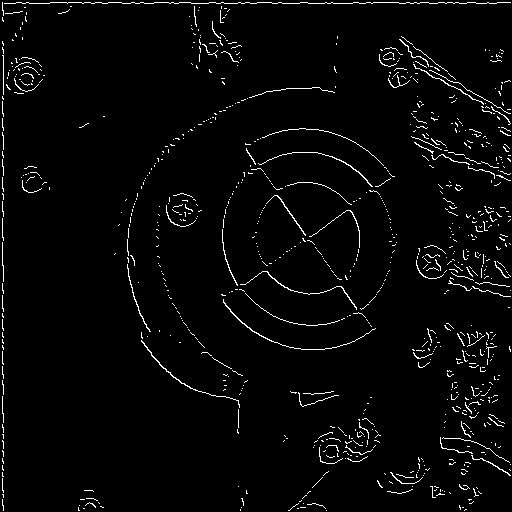

In [862]:
lines = HoughTransform.run(np_img)
img_show(lines)